In [1]:
import sys

sys.path.insert(0, '..')

## Setup the model area

In [2]:
from morpheus.project.types.discretization import SpatialDiscretization
from morpheus.project.types.discretization.spatial import Rotation, Grid, Crs
from morpheus.project.types.geometry import Polygon, LineString

polygon = Polygon(
  type='Polygon',
  coordinates=[[
    (13.92, 50.964),
    (13.92, 50.966),
    (13.925, 50.966),
    (13.925, 50.964),
    (13.92, 50.964)
  ]]
)

rotation = Rotation(0)

grid = Grid.cartesian_from_polygon(polygon=polygon, n_cols=100, n_rows=50, rotation=rotation)
spatial_discretization = SpatialDiscretization.from_geometry_with_grid(
  geometry=polygon,
  grid=grid,
  crs=Crs.from_str('EPSG:4326')
)

## Setup Time Discretization

In [3]:
from morpheus.project.types.discretization.time.TimeUnit import TimeUnit
from morpheus.project.types.discretization.time.Stressperiods import StartDateTime, StressPeriodCollection, \
  StressPeriod, NumberOfTimeSteps, TimeStepMultiplier, IsSteadyState
from morpheus.project.types.discretization.time import TimeDiscretization
from datetime import datetime

time_discretization = TimeDiscretization(
  start_date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
  end_date_time=StartDateTime.from_datetime(datetime(2020, 12, 31)),
  stress_periods=StressPeriodCollection([
    StressPeriod(
      start_date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
      number_of_time_steps=NumberOfTimeSteps(1),
      time_step_multiplier=TimeStepMultiplier(1),
      steady_state=IsSteadyState.yes()
    ),
  ]),
  time_unit=TimeUnit.days()
)

# Setup Model

In [4]:
from morpheus.project.types.Model import Model

model = Model.new()
model = model.with_updated_time_discretization(time_discretization)
model = model.with_updated_spatial_discretization(spatial_discretization=spatial_discretization)

In [5]:
import folium

m = folium.Map(tiles="cartodbpositron", crs="EPSG3857", zoom_start=12, location=[50.965, 13.922])
m.add_child(folium.GeoJson(polygon.as_geojson()))

m.fit_bounds(m.get_bounds())
m

# Setup general head boundaries with two observations

In [6]:
from morpheus.project.types.boundaries.Observation import ObservationName
from morpheus.project.types.boundaries.GeneralHeadObservation import ObservationId, GeneralHeadRawDataItem, \
  GeneralHeadObservation, Stage, Conductance
from morpheus.project.types.geometry import Point
from morpheus.project.types.boundaries.Boundary import BoundaryName, BoundaryCollection
from morpheus.project.types.boundaries.Boundary import GeneralHeadBoundary


general_head_east = GeneralHeadBoundary.from_geometry(
  name=BoundaryName('general_head_east'),
  geometry=LineString([
    (13.92499, 50.966),
    (13.92499, 50.964),
  ]),
  grid=grid,
  affected_layers=[model.layers[0].layer_id],
  observations=[
    GeneralHeadObservation(
      observation_id=ObservationId.new(),
      observation_name=ObservationName.default(),
      geometry=Point((13.92499, 50.966)),
      data=[
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2019, 1, 1)),
          stage=Stage.from_float(100),
          conductance=Conductance.from_float(100),
        ),
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
          stage=Stage.from_float(100),
          conductance=Conductance.from_float(100),
        ),
      ]
    ),
  ]
)

general_head_west = GeneralHeadBoundary.from_geometry(
  name=BoundaryName('general_head_west'),
  geometry=LineString([
    (13.92004, 50.96401),
    (13.92004, 50.96599),
  ]),
  grid=grid,
  affected_layers=[model.layers[0].layer_id],
  observations=[
    GeneralHeadObservation(
      observation_id=ObservationId.new(),
      observation_name=ObservationName.default(),
      geometry=Point((13.92004, 50.96599)),
      data=[
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2019, 1, 1)),
          stage=Stage.from_float(100),
          conductance=Conductance.from_float(300),
        ),
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
          stage=Stage.from_float(100),
          conductance=Conductance.from_float(300),
        ),
      ]
    ),
  ]
)

boundary_collection = BoundaryCollection.new()
boundary_collection.add_boundary(general_head_west)
boundary_collection.add_boundary(general_head_east)

model = model.with_updated_boundaries(boundaries=boundary_collection)

m.add_child(folium.GeoJson(general_head_east.as_geojson()))
m.add_child(folium.GeoJson(general_head_east.affected_cells.to_geojson(grid).as_geojson()))
for observation in general_head_east.observations:
  m.add_child(folium.GeoJson(observation.as_geojson()))

m.add_child(folium.GeoJson(general_head_west.as_geojson()))
m.add_child(folium.GeoJson(general_head_west.affected_cells.to_geojson(grid).as_geojson()))
for observation in general_head_west.observations:
  m.add_child(folium.GeoJson(observation.as_geojson()))
m.fit_bounds(m.get_bounds())
m

# Setup Recharge Boundary

In [7]:
from morpheus.project.types.boundaries.Boundary import RechargeBoundary
from morpheus.project.types.boundaries.RechargeObservation import RechargeRawDataItem, RechargeRate

recharge_area = Polygon(
  type='Polygon',
  coordinates=[[
    (
      13.92181326103696,
      50.96574333352123
    ),
    (
      13.92181326103696,
      50.96440649737727
    ),
    (
      13.923994608237564,
      50.96440649737727
    ),
    (
      13.923994608237564,
      50.96574333352123
    ),
    (
      13.92181326103696,
      50.96574333352123
    )
  ]]

)

recharge = RechargeBoundary.from_geometry(
  name=BoundaryName('recharge'),
  geometry=recharge_area,
  grid=grid,
  affected_layers=[model.layers[0].layer_id],
  data=[
    RechargeRawDataItem(
      date_time=StartDateTime.from_datetime(datetime(2019, 1, 1)),
      recharge_rate=RechargeRate.from_float(0.001),
    ),
    RechargeRawDataItem(
      date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
      recharge_rate=RechargeRate.from_float(0.001),
    ),
  ]
)

boundary_collection.add_boundary(recharge)

m.add_child(folium.GeoJson(recharge.as_geojson()))
m.add_child(folium.GeoJson(recharge.affected_cells.to_geojson(grid).as_geojson()))
m.fit_bounds(m.get_bounds())
m

In [8]:
from morpheus.project.infrastructure.calculation.engines.modflow_2005.packages.RchPackageMapper import calculate_rch_boundary_stress_period_data

result = calculate_rch_boundary_stress_period_data(
  spatial_discretization=spatial_discretization,
  time_discretization=time_discretization,
  layers=model.layers,
  rch_boundary=recharge,
)
result.to_dict()[0]

[[0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0

## Calculate

In [9]:
from morpheus.project.types.calculation.CalculationProfile import CalculationProfile, CalculationEngineType
from morpheus.project.types.calculation.Calculation import Calculation

calculation_profile = CalculationProfile.new(CalculationEngineType.MF2005)
calculation = Calculation.new(model=model, calculation_profile=calculation_profile)

In [10]:
calculation = Calculation.from_dict(calculation.to_dict())
calculation.calculation_id

CalculationId(value='919ff268-b8f3-4c93-b161-5bcbf0b5f886')

In [11]:
from morpheus.project.infrastructure.calculation.services.CalculationService import CalculationService

calculation_service = CalculationService.from_calculation(calculation)
calculation_service.calculate()

Model(model_id=ModelId(value='b65cb13c-f264-4cf3-8a88-5d7f795c3231'), spatial_discretization=SpatialDiscretization(geometry=Polygon(coordinates=[[(13.92, 50.964), (13.92, 50.966), (13.925, 50.966), (13.925, 50.964), (13.92, 50.964)]], type='Polygon'), grid=Grid(origin=Point(coordinates=(13.920000000000002, 50.965999999999994), type='Point'), col_widths=[5.565974539662712, 5.565974539662712, 5.565974539662712, 5.565974539662712, 5.565974539662712, 5.565974539662712, 5.565974539662712, 5.565974539662712, 5.5659745396627045, 5.565974539662719, 5.565974539662712, 5.565974539662712, 5.5659745396627045, 5.565974539662719, 5.5659745396627045, 5.565974539662719, 5.565974539662719, 5.56597453966269, 5.565974539662719, 5.565974539662719, 5.5659745396627045, 5.565974539662719, 5.565974539662719, 5.5659745396627045, 5.5659745396627045, 5.5659745396627045, 5.565974539662733, 5.5659745396627045, 5.5659745396627045, 5.5659745396627045, 5.5659745396627045, 5.565974539662733, 5.5659745396627045, 5.5659

In [12]:
calculation_service.get_result()

CalculationResult(type=<CalculationResultType.SUCCESS: 'success'>, message='Calculation finished successfully', files=['b65cb13c-f264-4cf3-8a88-5d7f795c3231.pcg', 'b65cb13c-f264-4cf3-8a88-5d7f795c3231.hds', 'b65cb13c-f264-4cf3-8a88-5d7f795c3231.rch', 'b65cb13c-f264-4cf3-8a88-5d7f795c3231.oc', 'b65cb13c-f264-4cf3-8a88-5d7f795c3231.ghb', 'b65cb13c-f264-4cf3-8a88-5d7f795c3231.dis', 'b65cb13c-f264-4cf3-8a88-5d7f795c3231.list', 'b65cb13c-f264-4cf3-8a88-5d7f795c3231.nam', 'b65cb13c-f264-4cf3-8a88-5d7f795c3231.bas', 'b65cb13c-f264-4cf3-8a88-5d7f795c3231.lpf'], head_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=1, number_of_observations=0), drawdown_results=None, budget_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=0, number_of_observations=0), concentration_results=None)

In [13]:
head = calculation_service.read_head(0, 0)

In [14]:
import simplejson as json

json = json.dumps(head, ignore_nan=True)
json

'[[100.00199890136719, 100.39900207519531, 100.7959976196289, 101.19300079345703, 101.58899688720703, 101.98600006103516, 102.38300323486328, 102.77899932861328, 103.1760025024414, 103.5719985961914, 103.96800231933594, 104.36399841308594, 104.76000213623047, 105.15499877929688, 105.55000305175781, 105.94400024414062, 106.33799743652344, 106.73100280761719, 107.1240005493164, 107.51499938964844, 107.90599822998047, 108.29499816894531, 108.68399810791016, 109.06999969482422, 109.45500183105469, 109.83799743652344, 110.21800231933594, 110.59600067138672, 110.97000122070312, 111.34100341796875, 111.70700073242188, 112.06800079345703, 112.4229965209961, 112.77200317382812, 113.11199951171875, 113.44400024414062, 113.76499938964844, 114.07499694824219, 114.37300109863281, 114.65699768066406, 114.9260025024414, 115.18000030517578, 115.41699981689453, 115.63700103759766, 115.83899688720703, 116.02300262451172, 116.18900299072266, 116.33499908447266, 116.46199798583984, 116.56999969482422, 116

In [15]:
calculation_service.read_drawdown(0, 0)

[]

In [16]:
calculation_service.read_budget(0, False)

{'STORAGE_IN': 0.0,
 'CONSTANT_HEAD_IN': 0.0,
 'HEAD_DEP_BOUNDS_IN': 0.0,
 'RECHARGE_IN': 21488.088,
 'TOTAL_IN': 21488.088,
 'STORAGE_OUT': -0.0,
 'CONSTANT_HEAD_OUT': -0.0,
 'HEAD_DEP_BOUNDS_OUT': -21488.088,
 'RECHARGE_OUT': -0.0,
 'TOTAL_OUT': -21488.088,
 'IN-OUT': 0.0,
 'PERCENT_DISCREPANCY': 0.0,
 'tslen': 365.0}

In [17]:
calculation_service.read_budget(0, True)

{'STORAGE_IN': 0.0,
 'CONSTANT_HEAD_IN': 0.0,
 'HEAD_DEP_BOUNDS_IN': 0.0,
 'RECHARGE_IN': 58.8715,
 'TOTAL_IN': 58.8715,
 'STORAGE_OUT': -0.0,
 'CONSTANT_HEAD_OUT': -0.0,
 'HEAD_DEP_BOUNDS_OUT': -58.8715,
 'RECHARGE_OUT': -0.0,
 'TOTAL_OUT': -58.8715,
 'IN-OUT': 0.0,
 'PERCENT_DISCREPANCY': 0.0,
 'tslen': 365.0}

In [18]:
calculation_service.get_result()

CalculationResult(type=<CalculationResultType.SUCCESS: 'success'>, message='Calculation finished successfully', files=['b65cb13c-f264-4cf3-8a88-5d7f795c3231.pcg', 'b65cb13c-f264-4cf3-8a88-5d7f795c3231.hds', 'b65cb13c-f264-4cf3-8a88-5d7f795c3231.rch', 'b65cb13c-f264-4cf3-8a88-5d7f795c3231.oc', 'b65cb13c-f264-4cf3-8a88-5d7f795c3231.ghb', 'b65cb13c-f264-4cf3-8a88-5d7f795c3231.dis', 'b65cb13c-f264-4cf3-8a88-5d7f795c3231.list', 'b65cb13c-f264-4cf3-8a88-5d7f795c3231.nam', 'b65cb13c-f264-4cf3-8a88-5d7f795c3231.bas', 'b65cb13c-f264-4cf3-8a88-5d7f795c3231.lpf'], head_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=1, number_of_observations=0), drawdown_results=None, budget_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=0, number_of_observations=0), concentration_results=None)

/Users/ralf/Projects/inowas/morpheus/src/backend/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/ralf/Projects/inowas/morpheus/src/backend/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/ralf/Projects/inowas/morpheus/src/backend/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


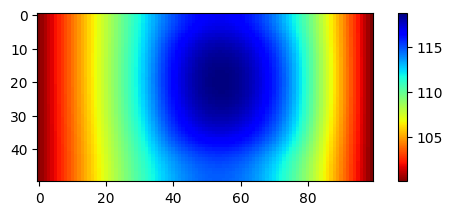

In [19]:
import matplotlib.pyplot as plt

heads = calculation_service.read_head(0, 0)
plt.subplot(2, 1, 1)
plt.imshow(heads, cmap='jet_r')
plt.colorbar()
plt.show()